<a href="https://colab.research.google.com/github/NotAndex/Demo/blob/main/Demo_for_Applications.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib as mpl

import plotly.graph_objects as go

from datetime import datetime, timedelta

from sklearn import preprocessing
from scipy.stats import spearmanr
import seaborn as sb

In [ ]:
today = datetime.today().date()
start_date = today - timedelta(days=365)
symbol = 'BTC-USD'

cc_data = yf.download(symbol, start=start_date, end=today)
cc_data.reset_index(inplace=True,col_fill=('Date'))
cc_data.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-05-29,9528.355469,9573.666992,9379.338867,9439.124023,9439.124023,32896642044
1,2020-05-30,9438.914062,9704.030273,9366.729492,9700.414062,9700.414062,32722975141
2,2020-05-31,9700.105469,9700.343750,9432.296875,9461.058594,9461.058594,27773290299
3,2020-06-01,9463.605469,10199.565430,9450.899414,10167.268555,10167.268555,35198901068
4,2020-06-02,10162.973633,10182.340820,9460.571289,9529.803711,9529.803711,39137252109


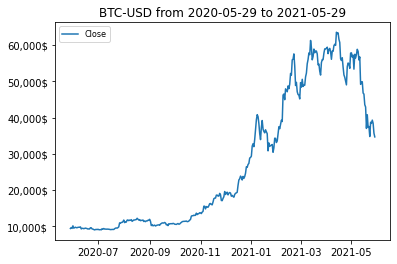

In [ ]:
fig1, ax1 = plt.subplots()
ax1.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}$'))
ax1.plot(cc_data['Date'], cc_data['Close'],label = 'Close')
ax1.set_title((f'{symbol} from {start_date} to {today}'), fontsize = 12)
ax1.legend(fontsize=8)

In [ ]:
fig1 = go.Figure(data=[go.Candlestick(x=cc_data['Date'],
                open = cc_data['Open'],
                high = cc_data['High'],
                low = cc_data['Low'],
                close = cc_data['Close'])])
fig1